In [1]:
import sys
sys.path.insert(0, "/kaggle/input/magnatagatune-pcm8-top50")
from magna_loader import MagnaLoader

In [2]:
mloader = MagnaLoader('/kaggle/input/magnatagatune-pcm8-top50/magnatagatune_pcm8_top50.bin')
mloader.samples_count

21108

In [3]:
import tensorflow as tf
import numpy as np
import gc

In [4]:
y_classes = 10
train_test_ratio = 0.9
test_x, test_y = [], []

from scipy import signal

def prepare_sample(x,y):
    x = x.reshape((-1, 1)) / 128
    y = y[:y_classes].astype(np.float32)    
    return x,y

x_usage = np.zeros(mloader.samples_count, dtype=np.int8)
for i, (x,y) in enumerate(mloader.iterate(prepare_sample)):
    if sum(y)==0: continue
    if i<train_test_ratio*mloader.samples_count:
        x_usage[i] = 1
    else:
        x_usage[i] = 2
        test_x.append(x)
        test_y.append(y)
        
test_x = np.array(test_x)
test_y = np.array(test_y)
gc.collect()

train_count = sum(x_usage==1)
print("Train count =", train_count)

def magna_generator():        
    while True:
        for i, (x,y) in enumerate(mloader.iterate(prepare_sample)):
            if x_usage[i]==1:
                yield x,y        

Train count = 14837


In [5]:
gc.collect()

0

In [6]:
test_x.shape, test_y.shape

((1635, 465984, 1), (1635, 10))

In [7]:
x_shape = test_x.shape[1:]
y_shape = (y_classes,)

In [8]:
magna_dataset = tf.data.Dataset.from_generator(magna_generator, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=(x_shape, y_shape))
batch_size = 16
magna_dataset = magna_dataset.shuffle(150).batch(batch_size)

In [9]:
def create_cnnlstm_model():
    conv_cfg = {'kernel_size':(3,), 'padding':'same', 'activation':'leaky_relu'}
    x = x0 = tf.keras.layers.Input(x_shape)
    x = tf.keras.layers.Conv1D(16, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(16, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(32, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(64, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(128, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(128, **conv_cfg)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(128, **conv_cfg)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.GlobalMaxPooling1D()(x)    
    x = tf.keras.layers.Dropout(0.1)(x)    
    x = tf.keras.layers.Dense(y_shape[-1], activation='sigmoid')(x)

    return tf.keras.models.Model(x0, x)

model = create_cnnlstm_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 465984, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 465984, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 155328, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 155328, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 155328, 16)          │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 51776, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 51776, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 51776, 32)           │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 17258, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 17258, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 17258, 64)           │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 5752, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 5752, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 5752, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 1917, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1917, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 1917, 128)           │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1917, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 639, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 639, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 639, 128)            │          49,2

 Total params: 134,202 (524.23 KB)

 Trainable params: 133,690 (522.23 KB)

 Non-trainable params: 512 (2.00 KB)

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [11]:
history = model.fit(magna_dataset, 
                   epochs=10,
                   steps_per_epoch=train_count//batch_size,
                   validation_data=(test_x, test_y))

Epoch 1/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 88s 81ms/step - binary_accuracy: 0.7901 - loss: 0.5194 - val_binary_accuracy: 0.8269 - val_loss: 0.3744
Epoch 2/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 63s 68ms/step - binary_accuracy: 0.8228 - loss: 0.4039 - val_binary_accuracy: 0.7413 - val_loss: 0.4310
Epoch 3/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 62s 67ms/step - binary_accuracy: 0.8314 - loss: 0.3831 - val_binary_accuracy: 0.8158 - val_loss: 0.3457
Epoch 4/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 61s 66ms/step - binary_accuracy: 0.8393 - loss: 0.3638 - val_binary_accuracy: 0.8194 - val_loss: 0.3394
Epoch 5/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 61s 66ms/step - binary_accuracy: 0.8413 - loss: 0.3584 - val_binary_accuracy: 0.8311 - val_loss: 0.3388
Epoch 6/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 61s 66ms/step - binary_accuracy: 0.8451 - loss: 0.3505 - val_binary_accuracy: 0.8597 - val_loss: 0.3085
Epoch 7/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 61s 66ms/step - binary_accuracy: 0.8472 - loss: 0.3437 - val_binary_accuracy: 0.8453 - val_loss:

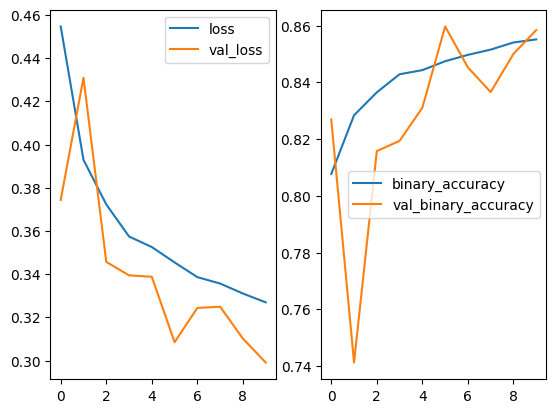

In [12]:
from matplotlib import pyplot as plt
fix, ax = plt.subplots(1,2)

ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].legend()

ax[1].plot(history.history['binary_accuracy'], label='binary_accuracy')
ax[1].plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
ax[1].legend()
plt.show()

In [13]:
del magna_dataset
gc.collect()

861

In [14]:
from sklearn.metrics import roc_curve
y_pred = model.predict(test_x)

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step


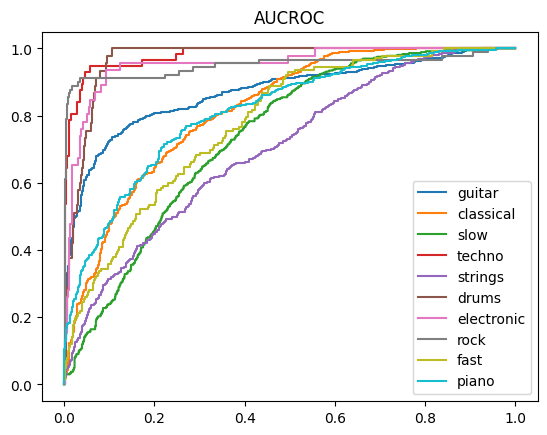

In [15]:
classes=["guitar", "classical", "slow", "techno", "strings", "drums", 
         "electronic", "rock", "fast", "piano"]
F = [None]*y_classes
T = [None]*y_classes
for i in range(y_classes):
    F[i], T[i], ths = roc_curve(test_y[:,i], y_pred[:,i], pos_label=1)
    plt.plot(F[i], T[i], label=classes[i])
plt.legend()
plt.title("AUCROC")
plt.show()

In [16]:
def auc(x,y):
    s = 0
    for i in range(1, len(x)):
        s += (y[i]+y[i-1])*abs((x[i]-x[i-1]))/2
    return s
for g, a in [(classes[i], auc(F[i], T[i])) for i in range(y_classes)]:
    print(g,a)

guitar 0.870619966639934
classical 0.8189034583237482
slow 0.7400053931614712
techno 0.9793042612865286
strings 0.7004955920541809
drums 0.9677568134171908
electronic 0.9526636933264017
rock 0.9503056454512765
fast 0.779152476816694
piano 0.8140885040885041


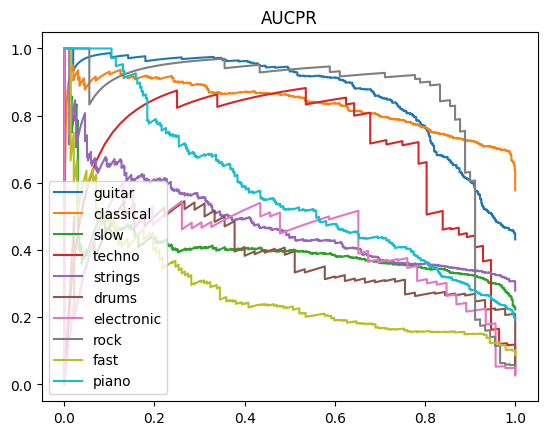

In [17]:
from sklearn.metrics import precision_recall_curve
P = [None]*y_classes
R = [None]*y_classes
for i in range(y_classes):
    P[i], R[i], ths = precision_recall_curve(test_y[:,i], y_pred[:,i], pos_label=1)
    plt.plot(R[i], P[i], label=classes[i])
plt.legend()
plt.title("AUCPR")
plt.show()

In [18]:
for g, a in [(classes[i], auc(R[i], P[i])) for i in range(y_classes)]:
    print(g,a)

guitar 0.8645597290055834
classical 0.8353821971186275
slow 0.39963839393884065
techno 0.6986338469911275
strings 0.4802970893353055
drums 0.3683247887520197
electronic 0.4056129069555192
rock 0.8498015395220584
fast 0.27693568442336436
piano 0.5769296020169865


In [19]:
from sklearn.metrics import confusion_matrix

for i in range(y_classes):
    print(classes[i])    
    cmat = confusion_matrix(test_y[:,i], y_pred[:,i]>=0.5)    
    print(cmat)
    p = cmat[0,0]/(cmat[0,0]+cmat[1,0])
    r = cmat[0,0]/(cmat[0,0]+cmat[0,1])
    print("Accuracy =", (cmat[0,0]+cmat[1,1])/(cmat[0,0]+cmat[0,1]+cmat[1,0]+cmat[1,1]))
    print("Prec =", p)
    print("Recall =", r)    
    print("F1 = ", 2*p*r/(p+r))

guitar
[[592 337]
 [ 92 614]]
Accuracy = 0.7376146788990826
Prec = 0.8654970760233918
Recall = 0.6372443487621098
F1 =  0.7340359578425295
classical
[[411 279]
 [144 801]]
Accuracy = 0.7412844036697248
Prec = 0.7405405405405405
Recall = 0.5956521739130435
F1 =  0.6602409638554217
slow
[[1112  158]
 [ 255  110]]
Accuracy = 0.7474006116207951
Prec = 0.8134601316752011
Recall = 0.8755905511811024
F1 =  0.8433826317785362
techno
[[1575    4]
 [  32   24]]
Accuracy = 0.9779816513761468
Prec = 0.9800871188550093
Recall = 0.9974667511082964
F1 =  0.9887005649717514
strings
[[1010  168]
 [ 289  168]]
Accuracy = 0.7204892966360856
Prec = 0.7775211701308699
Recall = 0.8573853989813243
F1 =  0.8155026241421074
drums
[[1582    8]
 [  38    7]]
Accuracy = 0.9718654434250764
Prec = 0.9765432098765432
Recall = 0.9949685534591195
F1 =  0.9856697819314643
electronic
[[1586    3]
 [  45    1]]
Accuracy = 0.9706422018348624
Prec = 0.9724095646842428
Recall = 0.9981120201384519
F1 =  0.9850931677018634
ro